<a href="https://colab.research.google.com/github/Location-Artistry/ColabNotebooks/blob/master/pandasAGOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import Libraries
**RUN FIRST**

In [ ]:
!pip install xlsxwriter
!pip install xlrd
!pip install openpyxl
!pip install arcgis

In [2]:
from pathlib import Path
import sys
import os
import datetime as dt
import time as time
import pandas 
from arcgis.gis import GIS, Item
from arcgis.env import active_gis
from arcgis.features import FeatureLayerCollection
from arcgis.mapping import WebMap
from IPython.display import display
import getpass
from pathlib import Path
from zipfile import ZipFile
from openpyxl import load_workbook

# Python Functions from my ArcGIS Python Colab Notebook  
**MUST RUN THIS CELL AFTER INSTALL AND IMPORT THEN - userLogin() -**


In [3]:
# Collection of all ArcGIS Python API Helper Functions
# user login functions, ask if user would like additional logins
def userLogin():
    userID = input(f'ArcGIS Online USER ID: ')
    passWord = getpass.getpass('PASSWORD: ')
    try:
        global gis
        gis = GIS("https://www.arcgis.com", userID, passWord)
        print(f'SUCCESS - CONNECTED TO: {gis.users.me.username} ACCOUNT as <gis>')
        print(gis)
        addUsers = input(f'Additional User Login(YES/NO)? ')
        if addUsers.upper() == 'YES':
            additionalUserLogin()
        else:
            print(f'YOU MAY NOW PROCEED...')
    except:
        print(f'ERROR DID NOT CONNECT TO: {userID}')

def additionalUserLogin():
    userID = input(f'ArcGIS Online USER ID: ')
    passWord = getpass.getpass('PASSWORD: ')
    try:
        global gis2
        gis2 = GIS("https://www.arcgis.com", userID, passWord)
        print(f'SUCCESS - CONNECTED TO: {gis2.users.me.username} ACCOUNT as <gis2>')
        print(gis2)
    except:
        print(f'ERROR DID NOT CONNECT TO: {userID}')

# get list of all owner AGOL items, print list with title, id, type, and categories
def getUserContent(gisInfo):
    try:
        my_content = gisInfo.content.search(query="owner:" + gisInfo.users.me.username, item_type="", max_items=200)
        for x in my_content:
            print(f'{x.title} - {x.id} - {x.type} - {x.categories}')          
            # print(x.title +' - ' + x.id + ' - ' + x.type + ' -',x.categories)
    except:
        print('ERROR could not get user content')

# Clone item using id of item passed to function
def cloneItem(gisInfo, gisInfo2, cloneID):    
    try:
        itemToClone = gisInfo.content.get(cloneID)
        print('Cloning:' + itemToClone.title + ' - ' + itemToClone.id + ' -',itemToClone.type)
        clonedItem = gisInfo2.content.clone_items(items=[itemToClone])
        print(f'Cloned Item: {clonedItem[0]}')
        #return clonedItem
    except:
        print('ERROR Could Not Clone')

# find item by keywords and display text information
def searchByKeywords(gisInfo, searchKeywords):
    try:
        searchContent = gisInfo.content.search(query=f'{searchKeywords}', item_type='', max_items=50)
        for z in searchContent:
            print(f'title: {z.title} - itemID: {z.id} - type: {z.type} - dateEdited: ')
    except:
        print('ERROR Search not Successful')

# find item by keywords and display visual card
def searchByKeyViz(gisInfo, searchKeywords):
    try:
        searchContent = gisInfo.content.search(query=f'{searchKeywords}', item_type='', max_items=50)
        for z in searchContent:
            print(f'title: {z.title} - itemID: {z.id} - type: {z.type}')
            display(z)
    except:
        print('ERROR Search not Successful')
        
# return all keys and values for item when passed itemID string
def getItemKeysValues(gisInfo, idString):
    try:
        getFeature = gisInfo.content.get(idString)
        for key, value in getFeature.items():
            print(key,': ', value)
    except:
        print('ERROR GET Keys/Values not Successful')
        
# takes itemID and gets and returns layerObject if exist, otherwise 'no layers found'
def getLayers(gisInfo, idString):
    getFeature = gisInfo.content.get(idString)
    try:
        featureLayers = getFeature.layers
        z = 0 
        for x in featureLayers:
            print(f'Layer {z}: {x}')
            z += 1
    except:
        print('no layers found')
    return featureLayers

# supply feature layer itemID, and the layer number to display table head 
def getLayerTable(gisInfo, idString, layerNum):
    try:
        layerOutput = getLayers(gisInfo, idString)
        queryLayer = layerOutput[layerNum].query()
        display(queryLayer.sdf.head())
    except:
        print('ERROR no Layers Found')
        
# delete item by itemID
def deleteItem(gisInfo, idString):
    itemToDelete = gisInfo.content.get(idString)
    display(itemToDelete)
    delQuest = input(f'Are you sure you want to delete: {itemToDelete.title}')
    try:
        if delQuest.upper() == 'YES':
            print(f'DELETING: {itemToDelete.title}')
            itemToDelete.delete()
        else:
            print(f'NOT DELETING: {itemToDelete.title}')
    except:
        print(f'ERROR failed to DELETE: {itemToDelete.title}')

# List all user Dashboards and Dashboard Webmmaps
def ListAllDashWebmaps(gisInfo):
  source_admin_inventory = get_user_items(gisInfo, gisInfo.users.me)
  x = 0
  try:
    for dashboard in source_admin_inventory['Dashboard']:
        print(x, dashboard)
        dashWebmap = get_dash_wm(gisInfo, dashboard)
        print(dashWebmap)
        x += 1
  except:
    print("ERROR COULD NOT LIST DASHBOARDS") 

# generic function update targetLayer Features based on Table Records
def updateLayFeatFromTable(gisInfo, targetLayerID, matchAttrib, targetAttrib, sourceAttrib):
  try:
    getLayers = gisInfo.content.get(targetLayerID)
    targetLayer = getLayers.layers
    layerFeatures = targetLayer[0].query()
    sourceTable = getLayers.tables
    tableFeatures = sourceTable[0].query()
    for tableFeature in tableFeatures:
      tableFeatureID = tableFeature.attributes[matchAttrib]
      for layerFeature in layerFeatures:
        layerFeatureID = layerFeature.attributes[matchAttrib]
        if tableFeatureID == layerFeatureID:
          targetValue = tableFeature.attributes[sourceAttrib]
          layerFeature.set_value(targetAttrib, targetValue)
          print(f'feature: {layerFeatureID} from tableFeature: {tableFeatureID} set {targetAttrib} as: {targetValue}')
    layerEdits = targetLayer[0].edit_features(updates=layerFeatures)
    editCounter = 0
    for edits in layerEdits['updateResults']:
      editCounter+=1
    print(f'updated {getLayers.title} with {editCounter} edits from {getLayers.tables[0]}')
  except:
    print(f'update features failed for {getLayers.title}')
  
# generic function update targetLayer Features based on Table Record, adds break list for parameter categories mapping/analysis
def updateLayFeatFromTableBreaks(gisInfo, targetLayerID, matchAttrib, targetAttrib, sourceAttrib, breaksList):
  try:
    getLayers = gisInfo.content.get(targetLayerID)
    targetLayer = getLayers.layers
    layerFeatures = targetLayer[0].query()
    sourceTable = getLayers.tables
    tableFeatures = sourceTable[0].query()
    for tableFeature in tableFeatures:
      tableFeatureID = tableFeature.attributes[matchAttrib]
      for layerFeature in layerFeatures:
        layerFeatureID = layerFeature.attributes[matchAttrib]
        if tableFeatureID == layerFeatureID:
          targetValue = tableFeature.attributes[sourceAttrib]
          x = 1
          for breakVal in breaksList:
            if targetValue > breakVal:
              print('nuthin')
            else:
              layerFeature.set_value(targetAttrib, x)
              print(f'feature: {layerFeatureID} from tableFeature: {tableFeatureID} set {targetAttrib}: {targetValue} as: {x}')
              break
            x+=1
    layerEdits = targetLayer[0].edit_features(updates=layerFeatures)
    editCounter = 0
    for edits in layerEdits['updateResults']:
      editCounter+=1
    print(f'updated {getLayers.title} with {editCounter} edits from {getLayers.tables[0]}')
  except:
    print(f'update features failed for {getLayers.title}')

# download Feature Layer data from AGOL, unzip contents to folder with item.title name
# Export Formats: Shapefile | CSV | File Geodatabase | Feature Collection | GeoJson | Scene Package | KML | Excel
def downloadItem(gisInfo, idString):
    try:
        downloadData = gisInfo.content.get(idString)
        dataPath = Path('/data')
        print(f'Downloading: {downloadData.title} to {dataPath} directory')
        if not dataPath.exists():
          dataPath.mkdir()
        # this portion for feature service
        downloadExport = downloadData.export(title=downloadData.title, export_format="CSV")
        zipPath = downloadExport.download(save_path=dataPath)
        # preparing to extract files to directory with item.title name
        #zipPath = downloadData.download(save_path=dataPath)
        extractPath = dataPath.joinpath(downloadData.title)
        # extract files to /data directory
        zipFiles = ZipFile(zipPath)
        zipFiles.extractall(path=extractPath)
        print(f'list of Files extracted to: {extractPath}')
        print(list(file.name for file in extractPath.glob('*')))
    except:
        print('ERROR DOWNLOAD did not workings!')
    
# *******ESRI pre-made helper functions********
def is_hosted(gisInfo, item):
    return [keyword for keyword in item.typeKeywords if "Hosted" in keyword] 

# Prints all layers in a webmap, very handy
def print_webmap_inventory(gisInfo, wm):
    wm_obj = WebMap(wm)
    print(f"{wm_obj.item.title}\n{'-'*100}")
    for wm_layer in wm_obj.layers:
        try:
            if is_hosted(Item(gisInfo, wm_layer['itemId'])):
                print(f"{' '*2}{wm_layer['title']:40}HOSTED{' ':5}"
                      f"{wm_layer['layerType']:20}{dict(wm_layer)['itemId']}")
            else:
                print(f"{' '*2}{wm_layer['title']:40}other{' ':6}"
                      f"{wm_layer['layerType']:20}{wm_layer.id}") 
        except:
            print(f"{' '*2}{wm_layer['title']:40}other{' ':6}"
                  f"{wm_layer['layerType']:20}{wm_layer.id}")
    print("\n")

def get_webmap_list(wm):
    wm_obj = WebMap(wm)
    wmList = []
    print(f"{wm_obj.item.title}\n{'-'*100}")
    for wm_layer in wm_obj.layers:
        # print(wm_layer.itemId)
        wmList.append(wm_layer.itemId)
    return(wmList)
    
def displayWebmapLayers(gisInfo, idList):
    for id in idList:
        displayLayer = gisInfo.content.get(id)
        display(displayLayer)

def get_user_items(gisInfo, user):
    user_inventory = {}
    user_items = gisInfo.content.search(query=f"* AND owner:{user.username}", 
                                           max_items=500)
    for item in user_items:
        if item.type not in user_inventory:
            user_inventory[item.type] = [i 
                                         for i in user_items 
                                         if i.type == item.type]
    return user_inventory

def print_user_inventory(inventory):
    for itype, ilist in inventory.items():
        try:
            print(f"{itype}\n{'-'*50}")
            for i in ilist:
                print(f"{' ':3}{i.title:50}")
            print("\n")
        except Exception as e:
            print(f"\t\tOperation failed on: {i.title}")
            print(f"\t\tException: {sys.exc_info()[1]}")
            continue
            
def get_dash_wm(gisInfo, dash):
    return [gisInfo.content.get(widget['itemId']) 
            for widget in dash.get_data()['widgets'] 
            if widget['type'] == "mapWidget"]

# Python API Function List  
**userLogin()** - **additionalUserLogin()** - **getUserContent** *(gisInfo)* - **cloneItem** *(gisInfo, gisInfo2, cloneID)*  
**searchByKeywords** *(gisInfo, searchKeywords)* - **searchByKeyViz** *(gisInfo, searchKeywords)*  
**getItemKeysValues** *(gisInfo, idString)* - **getLayers** *(gisInfo, idString)*  
**getLayerTable** *(gisInfo, idString, layerNum)* - **deleteItem** *(gisInfo, idString)*  
**ListAllDashWebmaps** *(gisInfo)* - **updateLayFeatFromTable** *(gisInfo, targetLayerID, matchAttrib, targetAttrib, sourceAttrib)*  
**updateLayFeatFromTableBreaks** *(gisInfo, targetLayerID, matchAttrib, targetAttrib, sourceAttrib, breaksList)*  
**downloadItem** *(gisInfo, idString)* 


---


# ESRI pre-made helper functions  
**is_hosted** *(gisInfo, item)* - **print_webmap_inventory** *(gisInfo, wm)* - **get_webmap_list** *(wm)*  
**displayWebmapLayers** *(gisInfo, idList)* - **get_user_items** *(gisInfo, user)*  
**print_user_inventory** *(inventory)* - **get_dash_wm** *(gisInfo, dash)*



# Work in Progress Cell(s)

In [5]:
userLogin()

ArcGIS Online USER ID: ekerney_nhbptribe
PASSWORD: ··········
SUCCESS - CONNECTED TO: ekerney_nhbptribe ACCOUNT as <gis>
GIS @ https://nhbptribe.maps.arcgis.com version:8.2
Additional User Login(YES/NO)? no
YOU MAY NOW PROCEED...


title: SAMPLE_DESIGN - itemID: a9fe52a2772448338f1e0cda3c61ee1e - type: Microsoft Excel


<Item title:"SAMPLE_DESIGN" type:Microsoft Excel owner:ekerney_nhbptribe>

title: WATER MONITORING 2020 - itemID: caecf40206c84c04824762b06681218b - type: Form


<Item title:"WATER MONITORING 2020" type:Form owner:ekerney_nhbptribe>
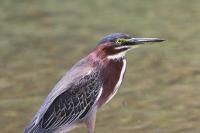

title: SAMPLE_DESIGN - itemID: 8cf416b413e24097a29f903090a4f981 - type: Feature Service


<Item title:"SAMPLE_DESIGN" type:Table Layer owner:ekerney_nhbptribe>
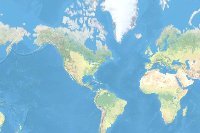

title: NHBP NIBI WATER 2020 - itemID: ba719e02dfb944cba4fa4dd27b685979 - type: Dashboard


<Item title:"NHBP NIBI WATER 2020" type:Dashboard owner:ekerney_nhbptribe>
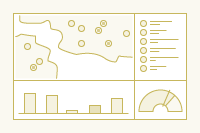

title: KZOO WATER DATA MAP 2020 - itemID: b7b5cbf904aa49ea8548993eedf88b99 - type: Web Map


<Item title:"KZOO WATER DATA MAP 2020" type:Web Map owner:ekerney_nhbptribe>
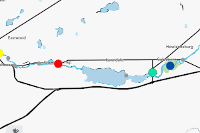

title: WATER SUPPLY UTILITY JUNE 2020 - itemID: 2ee940d58f1c4a24ac831bd4150440d3 - type: Web Map


<Item title:"WATER SUPPLY UTILITY JUNE 2020" type:Web Map owner:ekerney_nhbptribe>
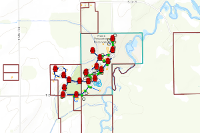

title: KZOO WATER MONITORING 2020 - itemID: ac3f5f4ccaea46079b03295c5e953226 - type: Form


<Item title:"KZOO WATER MONITORING 2020" type:Form owner:ekerney_nhbptribe>
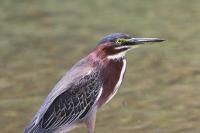

title: SAMPLE_DESIGN_KZOO - itemID: 726812e0054c434d90139624ff68c1d1 - type: Feature Service


<Item title:"SAMPLE_DESIGN_KZOO" type:Table Layer owner:ekerney_nhbptribe>
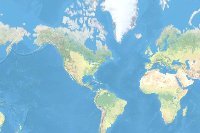

title: WATER_SAMPLING_2020 - itemID: 680016d676e746f98743f51d28abac60 - type: Feature Service


<Item title:"WATER_SAMPLING_2020" type:Feature Layer Collection owner:ekerney_nhbptribe>
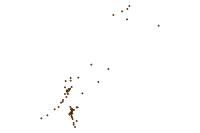

title: WATER DATA MAP 2020 - itemID: 405a4339e8fe471e934bf4ca09a5a8f9 - type: Web Map


<Item title:"WATER DATA MAP 2020" type:Web Map owner:ekerney_nhbptribe>
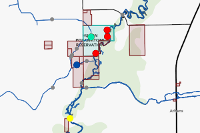

title: KZOO RIVER 2020 DASHBOARD - itemID: d88e57d46c9a48269ac795b55d29e424 - type: Dashboard


<Item title:"KZOO RIVER 2020 DASHBOARD" type:Dashboard owner:ekerney_nhbptribe>
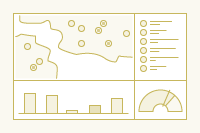

title: WATER_SAMPLING_KZOO - itemID: dff379381a6b4b73a1d80b9fd42784a8 - type: Feature Service


<Item title:"WATER_SAMPLING_KZOO" type:Feature Layer Collection owner:ekerney_nhbptribe>
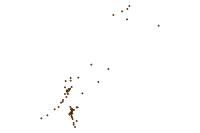

In [10]:
searchInput = 'water data 2020'
searchByKeyViz(gis, searchInput)

# Working to show readable date when item was updated
Trying for format ESRI UTC date into standard day-month-year: time

In [ ]:
# find item by keywords and display text information
def searchByKeywords(gisInfo, searchKeywords):
    try:
        searchContent = gisInfo.content.search(query=f'{searchKeywords}', item_type='', max_items=50)
        for z in searchContent:
          timeStruct = time.gmtime(z.modified)
          print(timeStruct.tm_mon)
          #timeFormatted = timeStruct.strftime("%m/%d/%Y %X")
          print(f'title: {z.title} - itemID: {z.id} - type: {z.type}  - dateEdited: {z.modified}')
    except:
        print('ERROR Search not Successful')

In [ ]:
x = dt.datetime.now()
print(x)
formattedTime = x.strftime("%m/%d/%Y %X")
print(formattedTime)
#print(timeRaw)
testTime = time.gmtime(1000)
print(testTime)
#print(x.year)
#print(x.strftime("%A"))
#datetimeVal = 
 #   formattedTime = datetime.strftime(datetimeVal, "%m/%d/%Y")

2020-07-22 14:46:49.102636
07/22/2020 02:46:49 PM
time.struct_time(tm_year=1970, tm_mon=1, tm_mday=1, tm_hour=0, tm_min=16, tm_sec=40, tm_wday=3, tm_yday=1, tm_isdst=0)


# Water Quality Dashboard Display Update Functions
Updated KZOO Turb Status 7-23-2020 3:05 pm
Updated NHBP DO Status 7-23-2020 3:08 pm

In [ ]:
kzooLayerNHBP = 'dff379381a6b4b73a1d80b9fd42784a8'
kzooLayerLA = '6b62d8b710e64b8abc79015fd7231b87'
waterSampNHBP = '680016d676e746f98743f51d28abac60'
match = 'SITE_ID'
turbTarget = 'TURB_STATUS_'
turbSource = 'TURB_NTU'
turbRefList = [3.93,10,40,1000]
DOtarget = 'DO_STATUS_'
DOsource = 'DO_mgl'
DOrefList = [5,6,7,100]
# calc Turbidity Status from most recent sample
# updateLayFeatFromTableBreaks(gis, kzooLayerNHBP, match, turbTarget, turbSource, turbRefList)
# calc DO Status from most recent sample
updateLayFeatFromTableBreaks(gis, waterSampNHBP, match, DOtarget, DOsource, DOrefList)

# **Explore Excel in Pandas**

In [ ]:
writer = pd.ExcelWriter('demo.xlsx', engine='xlsxwriter')
writer.save()

In [ ]:
df = pd.DataFrame({'NAME': ['A','B','C','D'], 'AGE': [10,0,30,50]})
writer = pd.ExcelWriter('demo.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1', index=False)
writer.save()

In [ ]:
df2 = pd.read_excel('demo.xlsx', index_col=None, no_values=['NA'])
df2.head()

In [ ]:
# new dataframe with same columns
df = pd.DataFrame({'Name': ['E','F','G','H'],
                   'Age': [100,70,40,60]})
writer = pd.ExcelWriter('demo.xlsx', engine='openpyxl')
# try to open an existing workbook
writer.book = load_workbook('demo.xlsx')
# copy existing sheets
writer.sheets = dict((ws.title, ws) for ws in writer.book.worksheets)
# read existing file
reader = pd.read_excel(r'demo.xlsx')
# write out the new sheet
df.to_excel(writer,index=False,header=False,startrow=len(reader)+1)
writer.close()
df2 = pd.read_excel('demo.xlsx', index_col=None, no_values=['NA'])
df2

# **Pandas Exploration of Titantic Dataset**

In [ ]:
titanticDF = pd.read_excel('TitanicTrain.xlsx', index_col=None, no_values=['NA'])

In [ ]:
titanticDF.head()

In [ ]:
titanticDF.describe()

In [ ]:
#titanticDF.drop()
pd.value_counts(titanticDF['Survived']).plot.bar()

In [ ]:
titanticDF['Survived'].mean()

0.3838383838383838

In [ ]:
titanticDF.groupby(['Sex']).mean()

In [ ]:
titanticDF.groupby(['Sex','Pclass']).mean()

In [ ]:
titanticDF[titanticDF['Age']<18].groupby(['Sex','Pclass']).mean()